<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1">Prepare data</a></span></li><li><span><a href="#Binary-classification" data-toc-modified-id="Binary-classification-2">Binary classification</a></span><ul class="toc-item"><li><span><a href="#Train-model" data-toc-modified-id="Train-model-2.1">Train model</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-2.2">Evaluate</a></span><ul class="toc-item"><li><span><a href="#Cross-validation-score" data-toc-modified-id="Cross-validation-score-2.2.1">Cross validation score</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-2.2.2">Confusion matrix</a></span></li><li><span><a href="#Precision/Recall-trade-off" data-toc-modified-id="Precision/Recall-trade-off-2.2.3">Precision/Recall trade-off</a></span></li><li><span><a href="#ROC-curve" data-toc-modified-id="ROC-curve-2.2.4">ROC curve</a></span></li></ul></li></ul></li></ul></div>

## Prepare data

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

print(f'Object class: {mnist.__class__}')

mnist.keys()

Object class: <class 'sklearn.utils.Bunch'>


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']

X.shape, y.shape

((70000, 784), (70000,))

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

Label: 5


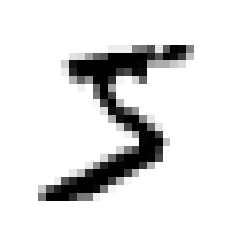

In [9]:
some_digit = X[0]
print('Label:', y[0])

some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary');
plt.axis('off');

In [10]:
y = y.astype(np.uint8)

In [11]:
train_size = 60000

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Binary classification

### Train model

In [12]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

### Evaluate

#### Cross validation score

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Predict using dummy classifier that always returns 0

In [21]:
from sklearn.dummy import DummyClassifier

never_5_clf = DummyClassifier(strategy='constant', constant=0)

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [27]:
print(f'Number of poisitive cases is {y_train_5.sum()} out of {len(y_train_5)}')

Number of poisitive cases is 5421 out of 60000


The dataset is highly unbalanced

#### Confusion matrix

In [29]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

y_train_pred.shape[0]

60000

In [30]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [31]:
# perfect classifier
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [32]:
from sklearn import metrics

metrics.precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [33]:
metrics.recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [34]:
metrics.f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision/Recall trade-off

In [35]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [37]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [39]:
# rising the threshold decreases recall

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [40]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [41]:
precisions, recalls, thresholds = metrics.precision_recall_curve(
    y_train_5, y_scores)

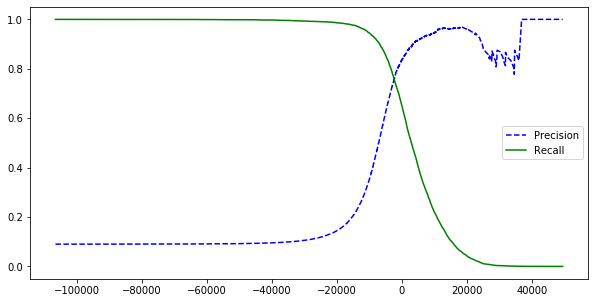

In [48]:
plt.figure(figsize=(10, 5))

plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall');
plt.legend();

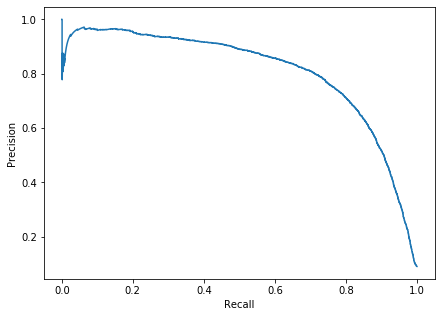

In [54]:
plt.figure(figsize=(7, 5))

plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision');

#### ROC curve